<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/shawal-mbalire/a2sv/blob/main/models.ipynb"><img src="https://quantumai.google/site-assets/images/buttons/colab_logo_1x.png" />Run in Google Colab</a>
  </td>
</table>


In [1]:
!pip install opendatasets pyloras scikit-optimize

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 3.6 MB/s eta 0:00:00


In [42]:
import numpy as np
import pandas as pd
import pyloras as pyl
import seaborn as sns
import xgboost as xgb
import opendatasets as od
import matplotlib.pyplot as plt
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import f1_score, roc_auc_score, classification_report,roc_curve

## Loading data

In [3]:
od.download("https://www.kaggle.com/datasets/bensalem14/sgcc-dataset")


Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: mukiibirogers
Your Kaggle Key: ··········
Dataset URL: https://www.kaggle.com/datasets/bensalem14/sgcc-dataset


100%|██████████| 51.2M/51.2M [00:00<00:00, 160MB/s]


In [4]:
df = pd.read_csv("sgcc-dataset/datasetsmall.csv")
df.head()

,01/01/2014,01/02/2014,01/03/2014,01/04/2014,01/05/2014,01/06/2014,01/07/2014,01/08/2014,01/09/2014,01/10/2014,...,1/19/2014,1/20/2014,1/21/2014,1/22/2014,1/23/2014,1/24/2014,1/25/2014,1/26/2014,CONS_NO,FLAG
0,2401.0,2500.0,2674.0,2432.00,2231.00,1942.00,2752.00,1244.00,2069.0,2360.0,...,1774.00,2089.0,1300.0,2419.0,2462.0,1177.00,340.00,2272.00,A0E791400CF1C48C43DC26A68227854A,1
1,3318.0,282.0,540.0,5670.00,4854.00,4170.00,4848.00,3546.00,4416.0,3966.0,...,3876.00,3228.0,3054.0,3840.0,1422.0,1956.00,1380.00,96.00,B415F931D3BFB17ACEF48BC648B04FC2,1
2,1020.8,1097.4,1377.4,1408.80,1414.80,1387.40,1444.60,1325.00,1461.6,1253.2,...,1214.60,1285.4,1279.6,1188.6,1362.6,1286.00,1267.60,1444.00,DE8E1EAE4E578C0CEF92D1E23499888F,1
3,0.0,1183.8,1190.4,1183.80,0.00,1154.40,1166.40,1183.80,1169.4,1174.2,...,0.00,1072.8,1090.8,1090.2,1101.0,1079.40,1121.40,1145.40,2952491E940C9040B188B3C9095910D6,0
4,1445.7,1348.2,1281.9,1276.35,1219.95,1289.85,1298.55,1326.15,1410.6,1376.7,...,1331.85,1392.9,1213.2,1463.1,1405.5,1240.05,1190.25,1455.45,DBEED8FD0E7F5E0D1BAF1F86F4983459,1


In [5]:
df.shape

(25863, 28)

In [6]:
# dropping CONS_NO because it is irrelevant
df.drop(columns=['CONS_NO'], inplace=True)

In [7]:
# adding 0 to the header dates without 0s at the start
new_cols=[]
for i in df.columns:
    if i[0]=='1':
        new_cols.append("0"+i)
    else :
        new_cols.append(i)

df.columns=new_cols
df.head()

,01/01/2014,01/02/2014,01/03/2014,01/04/2014,01/05/2014,01/06/2014,01/07/2014,01/08/2014,01/09/2014,01/10/2014,...,01/18/2014,01/19/2014,01/20/2014,01/21/2014,01/22/2014,01/23/2014,01/24/2014,01/25/2014,01/26/2014,FLAG
0,2401.0,2500.0,2674.0,2432.00,2231.00,1942.00,2752.00,1244.00,2069.0,2360.0,...,2369.0,1774.00,2089.0,1300.0,2419.0,2462.0,1177.00,340.00,2272.00,1
1,3318.0,282.0,540.0,5670.00,4854.00,4170.00,4848.00,3546.00,4416.0,3966.0,...,3258.0,3876.00,3228.0,3054.0,3840.0,1422.0,1956.00,1380.00,96.00,1
2,1020.8,1097.4,1377.4,1408.80,1414.80,1387.40,1444.60,1325.00,1461.6,1253.2,...,1351.4,1214.60,1285.4,1279.6,1188.6,1362.6,1286.00,1267.60,1444.00,1
3,0.0,1183.8,1190.4,1183.80,0.00,1154.40,1166.40,1183.80,1169.4,1174.2,...,1158.6,0.00,1072.8,1090.8,1090.2,1101.0,1079.40,1121.40,1145.40,0
4,1445.7,1348.2,1281.9,1276.35,1219.95,1289.85,1298.55,1326.15,1410.6,1376.7,...,1398.6,1331.85,1392.9,1213.2,1463.1,1405.5,1240.05,1190.25,1455.45,1


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25863 entries, 0 to 25862
Data columns (total 27 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   01/01/2014  25863 non-null  float64
 1   01/02/2014  25861 non-null  float64
 2   01/03/2014  25858 non-null  float64
 3   01/04/2014  25861 non-null  float64
 4   01/05/2014  25861 non-null  float64
 5   01/06/2014  25861 non-null  float64
 6   01/07/2014  25860 non-null  float64
 7   01/08/2014  25863 non-null  float64
 8   01/09/2014  25862 non-null  float64
 9   01/10/2014  25863 non-null  float64
 10  01/11/2014  25862 non-null  float64
 11  01/12/2014  25863 non-null  float64
 12  01/13/2014  25863 non-null  float64
 13  01/14/2014  25861 non-null  float64
 14  01/15/2014  25859 non-null  float64
 15  01/16/2014  25860 non-null  float64
 16  01/17/2014  25857 non-null  float64
 17  01/18/2014  25857 non-null  float64
 18  01/19/2014  25857 non-null  float64
 19  01/20/2014  25856 non-nul

## Data cleaning

In [9]:
# Handling missing values using interpolation
print(df.isna().sum().sum())

125


In [10]:
df.interpolate(method='linear', axis=1, inplace=True)

In [11]:
# Nomalization
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Standardization
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df)

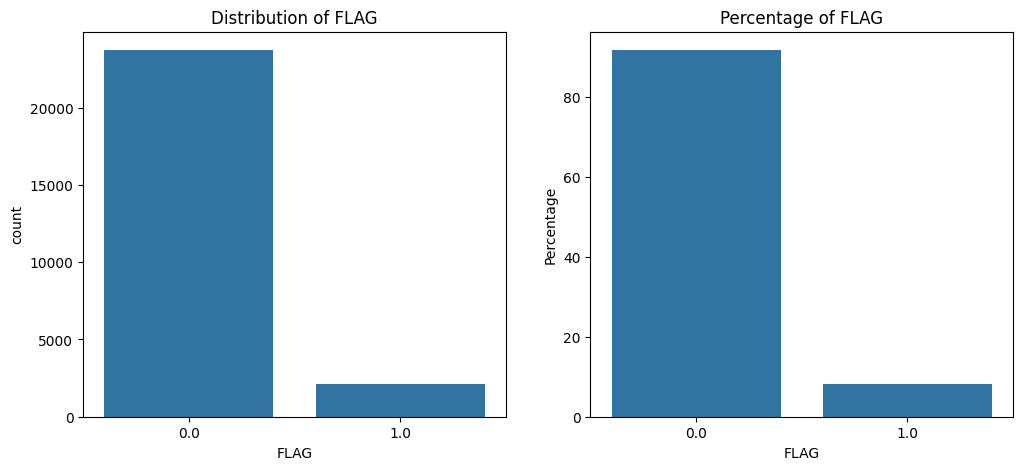

In [12]:
# plot for distribution of flag
fig, axs = plt.subplots(figsize=(12, 5), nrows=1, ncols=2)

axs = axs.flatten()
ax1 = axs[0]
ax2 = axs[1]
sns.countplot(x='FLAG', data=df, ax=axs[0])
ax1.set_title('Distribution of FLAG')

class_counts = df['FLAG'].value_counts(normalize=True) * 100
sns.barplot(x=class_counts.index, y=class_counts.values, ax=axs[1])
ax2.set_title('Percentage of FLAG')
ax2.set_xlabel('FLAG')
ax2.set_ylabel('Percentage')
plt.show();

### Formating data to 14-days datasets

In [13]:
def format_data(df):
  flag_column = df['FLAG']
  date_columns = df.columns[:-1]

  datasets = []

  window_size = 14
  for start in range(0, len(date_columns), window_size):
      end = start + window_size
      window_columns = date_columns[start:end]
      window_df = df[window_columns].copy()
      window_df['FLAG'] = flag_column
      datasets.append(window_df)

  return datasets

In [14]:
dfs = format_data(df)

### Data balancing

In [21]:
X_initial, y_initial = dfs[0].iloc[:, :-1], dfs[0]['FLAG']

X_train_initial, X_test, y_train_initial, y_test = train_test_split(X_initial, y_initial, test_size=0.05, random_state=42)

In [30]:
# Resampling the data
loras = pyl.LORAS()
X_train, y_train = loras.fit_resample(X_train_initial, y_train_initial)

## Model Development

### Feature Importance

In [31]:
# create the classifier with n_estimators = 100
clf = XGBClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)
feature_scores = pd.Series(clf.feature_importances_, index=X_train.columns).sort_values(ascending=False)
print(feature_scores)

01/10/2014    0.241834
01/11/2014    0.092332
01/08/2014    0.069994
01/03/2014    0.069463
01/01/2014    0.067181
01/12/2014    0.064861
01/09/2014    0.059617
01/14/2014    0.057012
01/05/2014    0.050438
01/04/2014    0.049271
01/07/2014    0.047938
01/13/2014    0.046157
01/02/2014    0.044555
01/06/2014    0.039348
dtype: float32


#### JayaOptmizer

Predictive modelling can be improved with the help of the JAYA Boost algorithm. The idea of 'teaching and learning' in nature was the inspiration for the JAYA optimization method. When used with boosting methods, it makes models more flexible. JAYA Boost can help optimize hyperparameters, improve model performance, and fine-tune the model's ability to pick up on subtle trends in data about how much energy is used, how the grid works, or how to spot anomalies. The Algorithm could be summed up as this

1. Initialise population size(50),number of variables (here we use 7) and termination criterion (find best within the range).
2. Identify best and worst solutions in the population.
3. Modify solutions based on best and worst (converge towrds the best away from worst).
4. Either find a better solution or keep the current one Until the termination criterion is met.

In [32]:
from sklearn.utils import check_random_state
# we use a python implentation of the jaya optimizing algorithm found here
# https://github.com/sorend/fylearn/blob/main/fylearn/jaya.py
class JayaOptimizer(object):
    """
    Jaya Algorithm is a population based optimizer which optimizes a function based on
    best and worst solutions in the population:

    1. Move towards the best solution

    2. Avoid the worst solution

    """
    def __init__(self, f, lower_bound, upper_bound,
                 n_population=50, random_state=None):
        """
        Constructor

        Parameters:
        -----------

        f : function to minimize.

        lower_bound : Vector with lower bound of the search space.

        upper_bound : Vector with upper bound of the search space.

        n_population : Number of individuals in the population [Default: 50].

        random_state : Specific random state to use [Default: None]
        """
        self.f = f
        self.lower_bound = lower_bound
        self.upper_bound = upper_bound
        self.pidx = range(n_population)
        self.m = lower_bound.shape[0]  # columns
        self.random_state = check_random_state(random_state)

        # init population and fitness
        self.population_ = self.random_state.rand(n_population, self.m) * (upper_bound - lower_bound) + lower_bound
        self.fitness_ = np.apply_along_axis(self.f, 1, self.population_)
        # init bestidx
        self.bestidx_ = np.argmin(self.fitness_)
        self.bestcosts_ = [ self.fitness_[self.bestidx_] ]

    def best(self):
        """
        Returns the best solution and fitness at current epoch
        """
        return self.population_[self.bestidx_], self.fitness_[self.bestidx_]

    def next(self):
        """
        One iteration of Jaya Algorithm
        """
        rs = self.random_state

        # find best and worst
        fitness_sorted = np.argsort(self.fitness_)
        best, worst = self.population_[fitness_sorted[0]], self.population_[fitness_sorted[-1]]

         # update using best and worst
        for i in self.pidx:
            r1_i, r2_i = rs.rand(self.m), rs.rand(self.m)  # random modification vectors

            # make new solution
            new_solution = (
                self.population_[i] +                            # old position
                (r1_i * (best - np.abs(self.population_[i]))) -  # move towards best solution
                (r2_i * (worst - np.abs(self.population_[i])))   # and avoid worst
            )

            # bound
            new_solution = np.minimum(self.upper_bound, np.maximum(self.lower_bound, new_solution))

            new_fitness = self.f(new_solution)

            if new_fitness < self.fitness_[i]:
                self.population_[i] = new_solution
                self.fitness_[i] = new_fitness

        self.bestidx_ = np.argmin(self.fitness_)  # update details
        self.bestcosts_.append(self.fitness_[self.bestidx_])

### Hyperparameter tuning with jaya

Instead of directly optimizing all the parameters of the xgboost, we will separate the optimization of the most important hyperparameter whcih is the learning rate from the others, the learning rate will be optimized using the baysian minimization, the best learning rate will then be saved and the others are going to be optimized using jaya.

In [33]:
#helper function
def create_param(params):
    return {
    'n_estimators': int(params[0]),
    'max_depth': int(params[1]),
    'learning_rate': params[2],
    'min_child_weight': int(params[3]),
    'gamma': params[4],
    'subsample': params[5],
    'colsample_bytree': params[6],
}

In [34]:
# Use Jara optimization to find the best XGBoost parameters
def optimize_xgboost(params):
    param_space = create_param(params)
    model = XGBClassifier(**param_space, random_state=42, n_jobs=-1)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return -f1_score(y_test, y_pred)  # Minimize F1 score (negative for optimization)

In [35]:
param_space_learning_rate = {
    'learning_rate': (0.001, 0.2),
}

In [36]:
from skopt import BayesSearchCV
from sklearn.metrics import make_scorer

neg_f1_scorer = make_scorer(f1_score, greater_is_better=True)
optimizer = BayesSearchCV(
    XGBClassifier(),
    param_space_learning_rate,
    n_iter=50,
    cv=5,
    n_jobs=-1,
    verbose=1,
    scoring=neg_f1_scorer  # Use an appropriate metric for your problem
)
_= optimizer.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [37]:
best_params = optimizer.best_params_
best_learning_rate=best_params['learning_rate']
print(best_learning_rate)

0.1999075468794162


In [38]:
param_space = {
    'n_estimators': (50, 200),
    'max_depth': (3, 10),
    'learning_rate': (best_learning_rate,best_learning_rate),
    'min_child_weight': (1, 10),
    'gamma': (0, 1),
    'subsample': (0.5, 1),
    'colsample_bytree': (0.5, 1),
}

In [39]:
#the implementation of the jaya requires a Numpy array

lower_bound = np.array([value[0] for key, value in param_space.items()])
upper_bound = np.array([value[1] for key, value in param_space.items()])
optimizer = JayaOptimizer(optimize_xgboost, upper_bound,lower_bound,random_state=42)
best_params = optimizer.best()[0]
print(best_params)

[124.59814652   9.63964874   0.19990755   1.82560703   0.76043811
   0.92755256   0.75527362]


In [40]:
# Train the XGBoost classifier on the optimized parameters
#the best recorded params during the experiment were
best_params = create_param(best_params)
xgb_classifier = XGBClassifier(**best_params, random_state=42, n_jobs=-1)
xgb_classifier.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.7552736198612184, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, feature_types=None, gamma=0.7604381093330276,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1999075468794162,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=9, max_leaves=None,
              min_child_weight=1, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=124, n_jobs=-1,
              num_parallel_tree=None, random_state=42, ...)

In [44]:
# convert initial datset to DMatrix
dtrain_initial = xgb.DMatrix(X_train_initial, label=y_train_initial)
dtest = xgb.DMatrix(X_test)

In [45]:
booster = xgb_classifier.get_booster()

In [53]:
for df in dfs:
    X, y = df.iloc[:, :-1], df['FLAG']
    # Resampling the data
    loras = pyl.LORAS()
    X_train_new, y_train_new = loras.fit_resample(X, y)

    # Align features of the new data with the initial training data
    X_train_new = X_train_new.reindex(columns=X_train_initial.columns, fill_value=0)

    dtrain_new = xgb.DMatrix(X_train_new, label=y_train_new)
    booster.update(dtrain_new, 0)

booster.save_model('booster.model')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:50:24] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)


In [54]:
xgb_classifier._Booster = booster

In [55]:
# Make predictions on the test set
y_pred = xgb_classifier.predict(X_test)

## Model Evaluation

In [56]:
# Calculate F1 score and AUC
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, xgb_classifier.predict_proba(X_test)[:, 1])

In [57]:
# Generate a classification report
class_report = classification_report(y_test, y_pred)

In [58]:
# Print results
print("Optimized XGBoost Parameters:")
print(best_params)
print("F1 Score:", f1)
print("AUC:", roc_auc)
print("Classification Report:\n", class_report)

Optimized XGBoost Parameters:
{'n_estimators': 124, 'max_depth': 9, 'learning_rate': 0.1999075468794162, 'min_child_weight': 1, 'gamma': 0.7604381093330276, 'subsample': 0.9275525639543885, 'colsample_bytree': 0.7552736198612184}
F1 Score: 0.20379965457685664
AUC: 0.6788819095477387
Classification Report:
               precision    recall  f1-score   support

         0.0       0.95      0.65      0.77      1194
         1.0       0.12      0.59      0.20       100

    accuracy                           0.64      1294
   macro avg       0.54      0.62      0.49      1294
weighted avg       0.89      0.64      0.73      1294



[[774 420]
 [ 41  59]]


<Axes: >

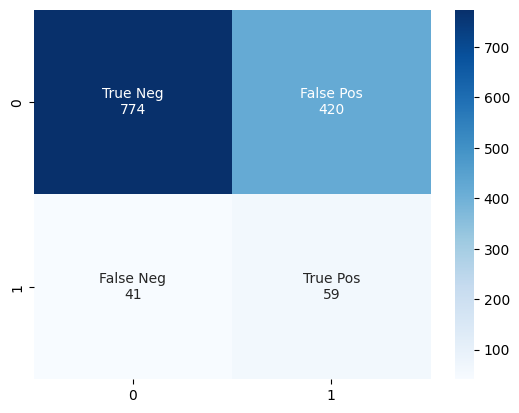

In [59]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
print(cf_matrix)
labels = ['True Neg\n'+str(cf_matrix[0][0]),'False Pos\n'+str(cf_matrix[0][1]),'False Neg\n'+str(cf_matrix[1][0]),'True Pos\n'+str(cf_matrix[1][1])]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')

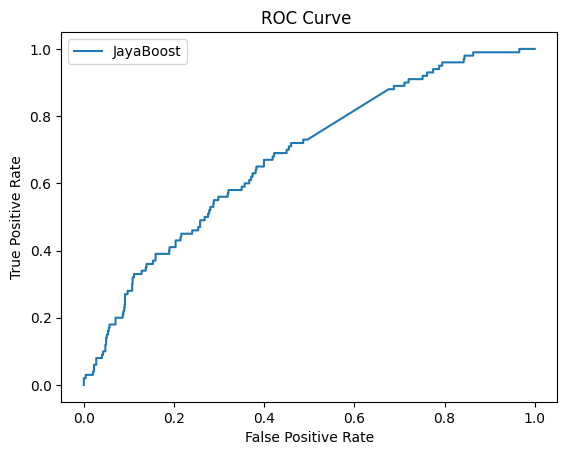

In [60]:
fpr_xg, tpr_xg, _ = roc_curve(y_test, xgb_classifier.predict_proba(X_test)[:, 1])
plt.plot(fpr_xg, tpr_xg, label='JayaBoost')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve ')
plt.legend()
plt.show()

## Save model


In [61]:
#save model
xgb_classifier.save_model('xgb_classifier.model')

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [18:53:35] WARNING: /workspace/src/c_api/c_api.cc:1240: Saving into deprecated binary model format, please consider using `json` or `ubj`. Model format will default to JSON in XGBoost 2.2 if not specified.
  warnings.warn(smsg, UserWarning)
